<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  
[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    print("Using GPU")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("Using CPU")

Using GPU


In [4]:
sns.set_style("white")

# Experiment Path

# Prepare Data

## Parameters

In [5]:
df = pd.read_csv("Full_CrossCheck_Hourly_Data.csv")
df = df.set_index("study_id").sort_index()
df = df.drop(["hour", "day", "filled_pct", "weighted_distance_sum"], axis=1)
df.head()

,accel_mean,app_lists_num_apps_opened_sum,call_log_duration_count_1,call_log_duration_count_2,call_log_duration_count_3,call_log_duration_count_5,call_log_duration_count_6,call_log_duration_sum_1,call_log_duration_sum_2,call_log_duration_sum_3,...,screen_sum_1hr_screen_duration_sum,sleep_duration,sleep_end,sleep_start,sms_log_is_read_count_1,sms_log_is_read_count_2,sms_log_is_read_count_3,sms_log_is_read_count_4,sms_log_is_read_count_5,sms_log_is_read_count_6
study_id,,,,,,,,,,,,,,,,,,,,,
2.0,10.042526,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,8.500000,80.000000,12.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2.0,0.000000,20.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,469.000000,0.0,...,280.022000,11.750000,94.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0
2.0,9.997664,0.202206,0.007353,0.113971,0.047794,0.0,0.011029,0.691176,11.672794,0.0,...,39.333881,8.452665,98.194853,30.573529,0.0,0.0,0.003676,0.0,0.0,0.0
2.0,9.962713,0.349265,0.003676,0.040441,0.018382,0.0,0.000000,0.036765,2.136029,0.0,...,41.894893,8.452665,98.194853,30.573529,0.0,0.0,0.000000,0.0,0.0,0.0
2.0,9.964148,0.454545,0.000000,0.007273,0.000000,0.0,0.000000,0.000000,1.578182,0.0,...,5.912537,8.465909,98.461818,30.734545,0.0,0.0,0.000000,0.0,0.0,0.0


In [6]:
seq_len = 24
n_seq = 27
batch_size = 128

In [7]:
# make a list of the columns in the dataframe
cols = df.columns.tolist()

## Plot Series

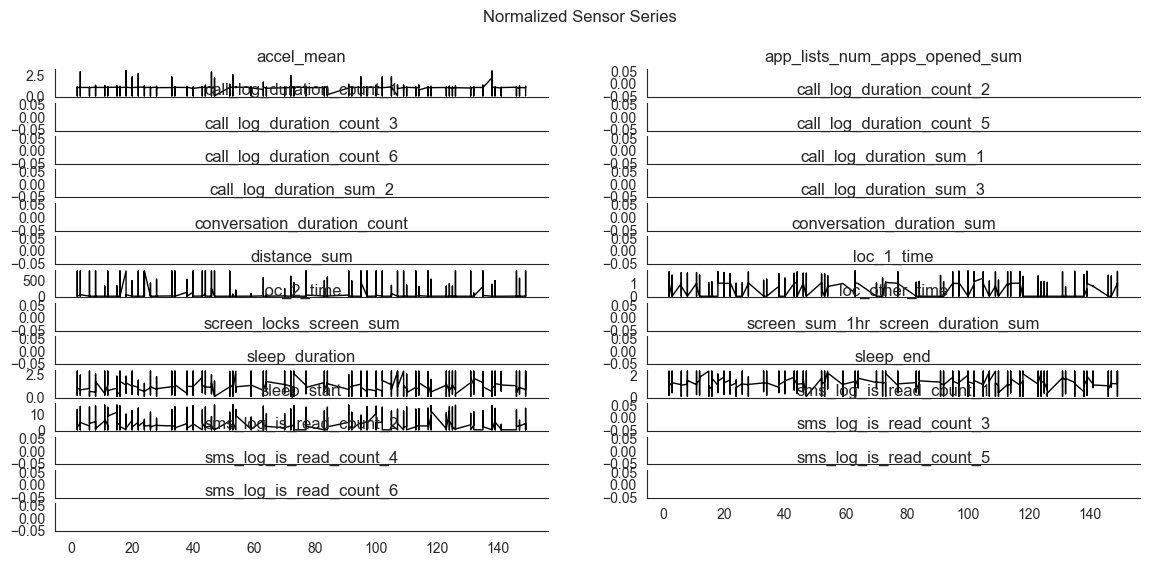

In [8]:
axes = df.div(df.iloc[0]).plot(
    subplots=True,
    figsize=(14, 6),
    layout=(14, 2),
    title=cols,
    legend=False,
    rot=0,
    lw=1,
    color="k",
)
for ax in axes.flatten():
    ax.set_xlabel("")

plt.suptitle("Normalized Sensor Series")
plt.gcf().tight_layout()
sns.despine()

## Correlation

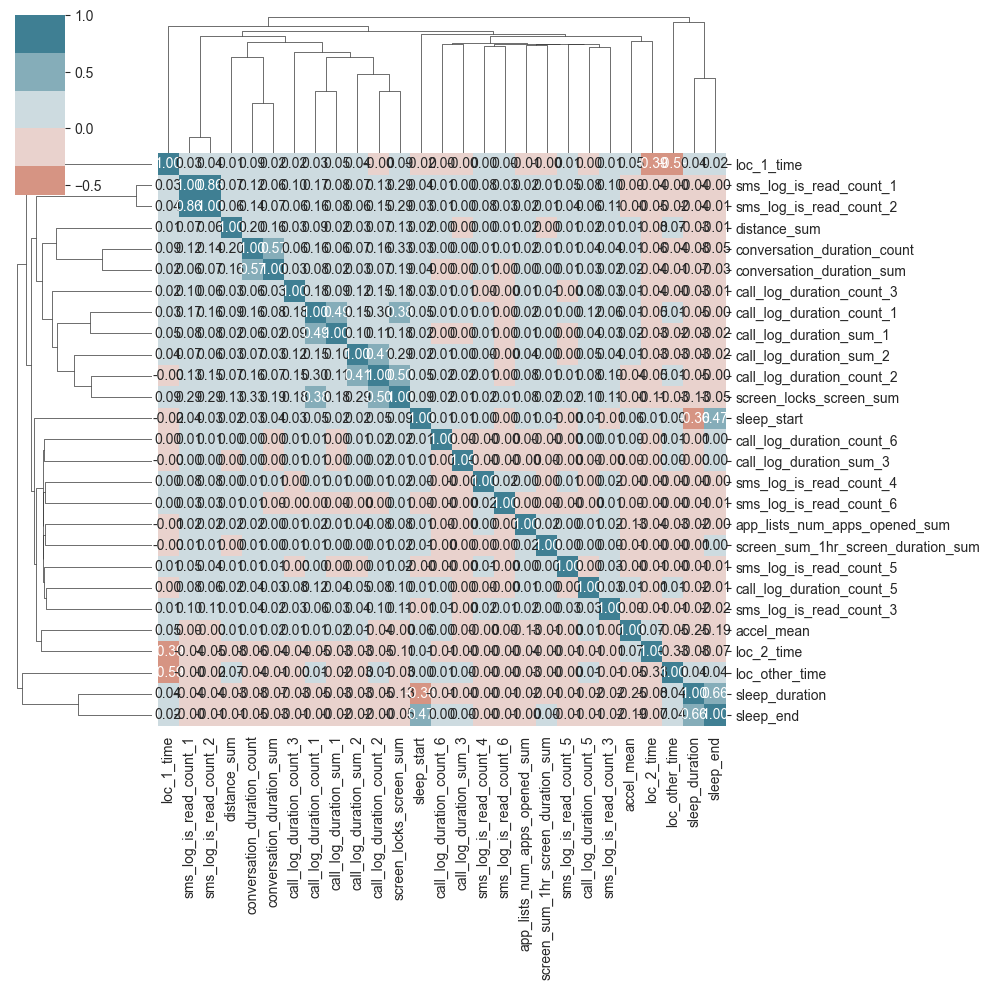

In [9]:
sns.clustermap(
    df.corr(),
    annot=True,
    fmt=".2f",
    cmap=sns.diverging_palette(h_neg=20, h_pos=220),
    center=0,
)

## Normalize Data

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [11]:
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i : i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [12]:
real_series = (
    tf.data.Dataset.from_tensor_slices(data)
    .shuffle(buffer_size=n_windows)
    .batch(batch_size)
)
real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [13]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [14]:
random_series = iter(
    tf.data.Dataset.from_generator(make_random_data, output_types=tf.float32)
    .batch(batch_size)
    .repeat()
)

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [15]:
hidden_dim = 43
num_layers = 3

## Input place holders

In [16]:
X = Input(shape=[seq_len, n_seq], name="RealData")
Z = Input(shape=[seq_len, n_seq], name="RandomData")

## RNN block generator

We keep it very simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

In [17]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential(
        [
            GRU(units=hidden_units, return_sequences=True, name=f"GRU_{i + 1}")
            for i in range(n_layers)
        ]
        + [Dense(units=output_units, activation="sigmoid", name="OUT")],
        name=name,
    )

## Embedder & Recovery

In [18]:
embedder = make_rnn(
    n_layers=3, hidden_units=hidden_dim, output_units=hidden_dim, name="Embedder"
)
recovery = make_rnn(
    n_layers=3, hidden_units=hidden_dim, output_units=n_seq, name="Recovery"
)

## Generator & Discriminator

In [19]:
generator = make_rnn(
    n_layers=3, hidden_units=hidden_dim, output_units=hidden_dim, name="Generator"
)
discriminator = make_rnn(
    n_layers=3, hidden_units=hidden_dim, output_units=1, name="Discriminator"
)
supervisor = make_rnn(
    n_layers=2, hidden_units=hidden_dim, output_units=hidden_dim, name="Supervisor"
)

# TimeGAN Training

## Settings

In [20]:
train_steps = 50000
gamma = 1

## Generic Loss Functions

In [21]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

In [22]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X, outputs=X_tilde, name="Autoencoder")

In [23]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 27)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 43)            33884     
                                                                 
 Recovery (Sequential)       (None, 24, 27)            35244     
                                                                 
Total params: 69,128
Trainable params: 69,128
Non-trainable params: 0
_________________________________________________________________


In [24]:
plot_model(autoencoder)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Autoencoder Optimizer

In [25]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [26]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

In [27]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)

100%|██████████| 50000/50000 [16:05<00:00, 51.77it/s] 


## Persist model

In [28]:
# autoencoder.save(log_dir / 'autoencoder')

# Phase 2: Supervised training

## Define Optimizer

In [29]:
supervisor_optimizer = Adam()

## Train Step

In [30]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

## Training Loop

In [31]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)

100%|██████████| 50000/50000 [09:48<00:00, 85.01it/s] 


## Persist Model

In [32]:
# supervisor.save(log_dir / 'supervisor')

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [33]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(
    inputs=Z, outputs=Y_fake, name="AdversarialNetSupervised"
)

In [34]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 27)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 43)            33884     
                                                                 
 Supervisor (Sequential)     (None, 24, 43)            24596     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             34100     
                                                                 
Total params: 92,580
Trainable params: 92,580
Non-trainable params: 0
_________________________________________________________________


In [35]:
plot_model(adversarial_supervised, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Adversarial Architecture in Latent Space

In [36]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name="AdversarialNet")

In [37]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 27)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 43)            33884     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             34100     
                                                                 
Total params: 67,984
Trainable params: 67,984
Non-trainable params: 0
_________________________________________________________________


In [38]:
plot_model(adversarial_emb, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Mean & Variance Loss

In [39]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z, outputs=X_hat, name="SyntheticData")

In [40]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 27)]          0         
                                                                 
 Generator (Sequential)      (None, 24, 43)            33884     
                                                                 
 Supervisor (Sequential)     (None, 24, 43)            24596     
                                                                 
 Recovery (Sequential)       (None, 24, 27)            35244     
                                                                 
Total params: 93,724
Trainable params: 93,724
Non-trainable params: 0
_________________________________________________________________


In [41]:
plot_model(synthetic_data, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(
        tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6))
    )
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [43]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X, outputs=Y_real, name="DiscriminatorReal")

In [44]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 27)]          0         
                                                                 
 Embedder (Sequential)       (None, 24, 43)            33884     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             34100     
                                                                 
Total params: 67,984
Trainable params: 67,984
Non-trainable params: 0
_________________________________________________________________


In [45]:
plot_model(discriminator_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Optimizers

In [46]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

In [47]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake), y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(
            y_true=tf.ones_like(y_fake_e), y_pred=y_fake_e
        )
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (
            generator_loss_unsupervised
            + generator_loss_unsupervised_e
            + 100 * tf.sqrt(generator_loss_supervised)
            + 100 * generator_moment_loss
        )

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [48]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [49]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real), y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake), y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e), y_pred=y_fake_e)
    return (
        discriminator_loss_real
        + discriminator_loss_fake
        + gamma * discriminator_loss_fake_e
    )

In [50]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

In [56]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
file_writer = tf.summary.create_file_writer("logs/fit")
file_writer.set_as_default()
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        tf.summary.scalar("Generator loss unsupervised", data=step_g_loss_u, step=step)
        tf.summary.scalar("Generator loss supervised", data=step_g_loss_s, step=step)
        tf.summary.scalar("Generator loss variance", data=step_g_loss_v, step=step)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)
        tf.summary.scalar("Embedder loss", data=step_e_loss_t0, step=step)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    tf.summary.scalar("Discriminator loss", data=step_d_loss, step=step)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(
            f"{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | "
            f"g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}"
        )
    tf.summary.flush()

     0 | d_loss: 1.9882 | g_loss_u: 0.8501 | g_loss_s: 0.0021 | g_loss_v: 0.0881 | e_loss_t0: 0.0315
 1,000 | d_loss: 1.7534 | g_loss_u: 1.1904 | g_loss_s: 0.0001 | g_loss_v: 0.0187 | e_loss_t0: 0.0043
 2,000 | d_loss: 1.6994 | g_loss_u: 1.0582 | g_loss_s: 0.0001 | g_loss_v: 0.0270 | e_loss_t0: 0.0052
 3,000 | d_loss: 1.6386 | g_loss_u: 1.3007 | g_loss_s: 0.0001 | g_loss_v: 0.0139 | e_loss_t0: 0.0050
 4,000 | d_loss: 1.7252 | g_loss_u: 1.0590 | g_loss_s: 0.0001 | g_loss_v: 0.0186 | e_loss_t0: 0.0045
 5,000 | d_loss: 1.7170 | g_loss_u: 1.1537 | g_loss_s: 0.0001 | g_loss_v: 0.0161 | e_loss_t0: 0.0054
 6,000 | d_loss: 1.5920 | g_loss_u: 1.1567 | g_loss_s: 0.0001 | g_loss_v: 0.0180 | e_loss_t0: 0.0044


## Persist Synthetic Data Generator

In [ ]:
log_dir = Path("logs/model")

In [ ]:
synthetic_data.save(log_dir / "synthetic_data")

INFO:tensorflow:Assets written to: logs\model\synthetic_data\assets


INFO:tensorflow:Assets written to: logs\model\synthetic_data\assets


# Generate Synthetic Data

In [ ]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [ ]:
len(generated_data)

3779

In [ ]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(483712, 24, 27)

In [ ]:
log_dir = Path("logs/data")

In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [ ]:
np.save(log_dir / "generated_data.npy", generated_data)

## Rescale

In [ ]:
generated_data = scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(
    -1, seq_len, n_seq
)
generated_data.shape

(483712, 24, 27)

## Persist Data

In [ ]:
# make a list of the columns in the dataframe
cols = df.columns.tolist()

In [ ]:
pd.DataFrame(generated_data.reshape(-1, n_seq), columns=cols).to_csv("synthetic.csv")

## Plot sample Series

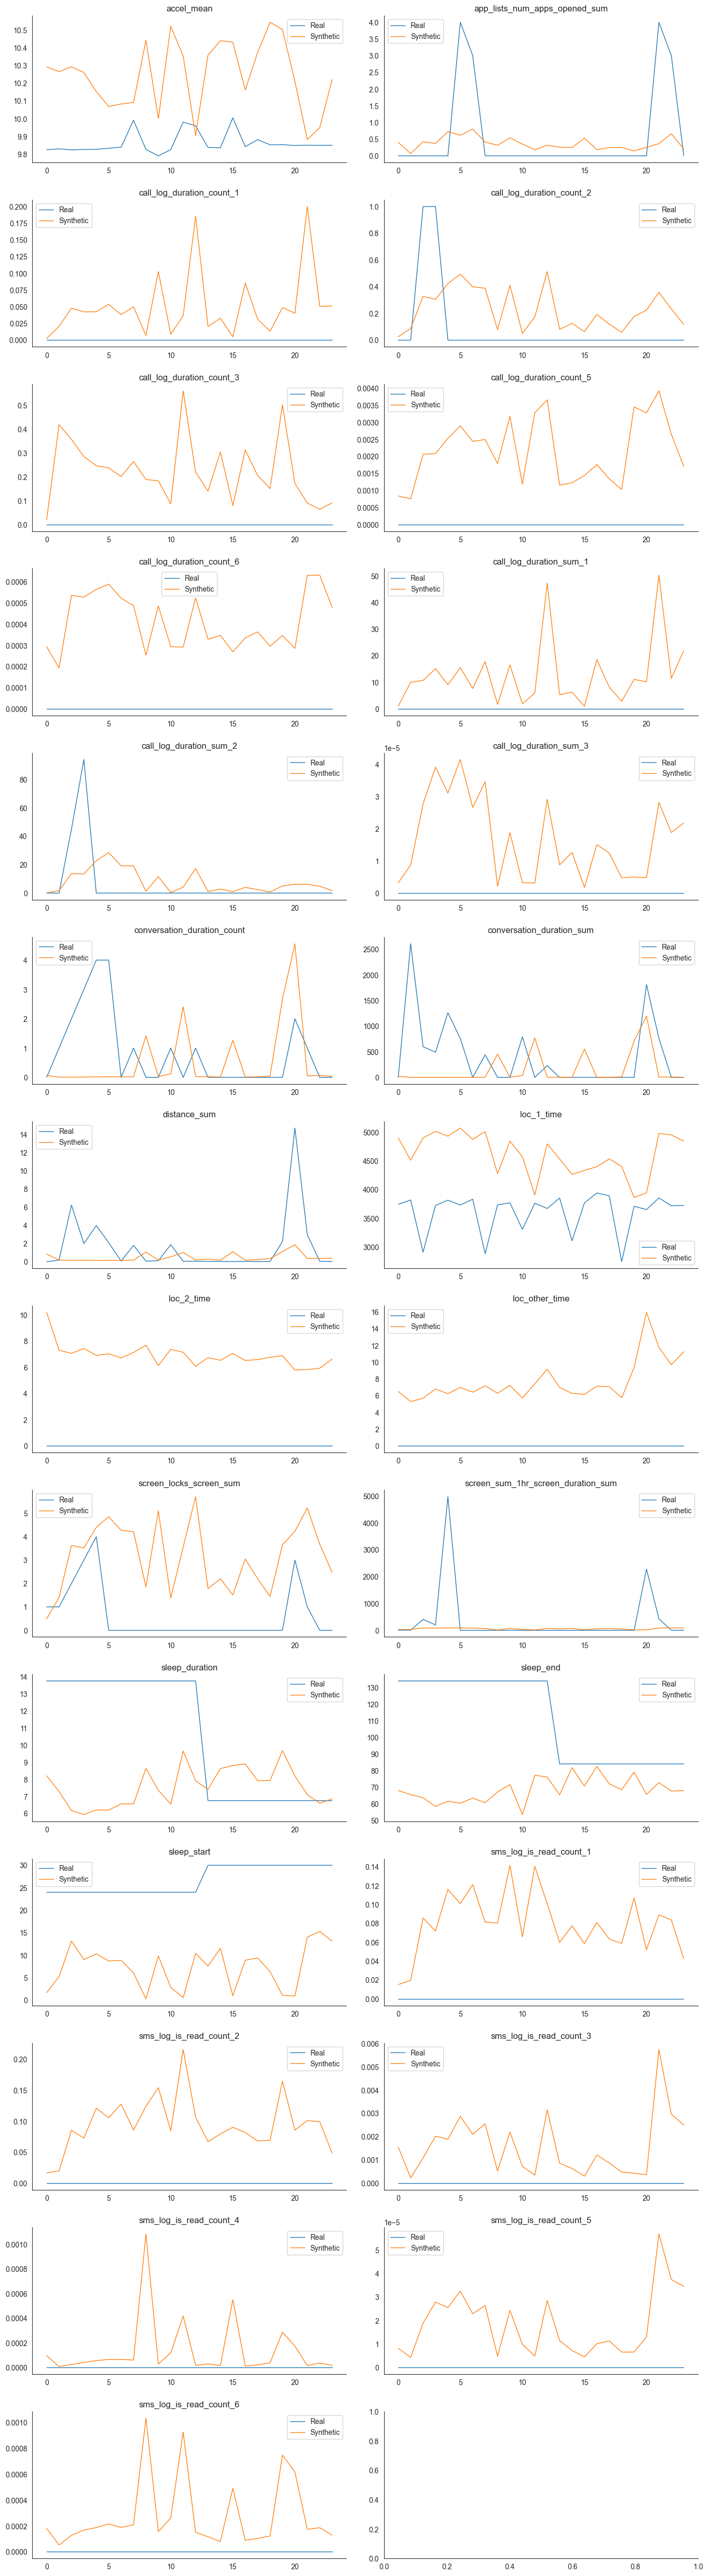

In [ ]:
## Plot Synthetic Overlapping Real Data Line Plots for Each of the 27 Features

fig, axes = plt.subplots(nrows=14, ncols=2, figsize=(14, 50))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx : idx + seq_len]

for j, col in enumerate(cols):
    ax = axes[j]
    pd.DataFrame({"Real": real.iloc[:, j].values, "Synthetic": synthetic[:, j]}).plot(
        ax=ax, title=col, lw=1
    )
    ax.legend()

sns.despine()
fig.tight_layout(pad=2.0)

<font size="+3">Visualize Real and Synthetic Data</font>

In [ ]:
seq_len = 24
n_seq = 27

# Load Data

In [ ]:
def get_real_data():
    df = pd.read_csv("Full_CrossCheck_Hourly_Data.csv")
    df = df.set_index("study_id").sort_index()
    df = df.drop(["hour", "day", "filled_pct"], axis=1)

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i : i + seq_len])
    return data

In [ ]:
real_data = get_real_data()

In [ ]:
n = len(real_data)

In [ ]:
np.asarray(real_data).shape

(483768, 24, 27)

In [ ]:
synthetic_data = np.load("logs/data/generated_data.npy")
synthetic_data.shape

(483712, 24, 27)

In [ ]:
real_data = real_data[: synthetic_data.shape[0]]

# Prepare Sample

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [ ]:
# Reshape real and synthetic samples
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)
real_sample_2d = real_sample.reshape(-1, seq_len)

In [ ]:
real_sample_2d.shape, synthetic_sample_2d.shape

((6750, 24), (6750, 24))

# Visualization in 2D: A Qualitative Assessment of Diversity

## Run PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = pd.DataFrame(pca.transform(real_sample_2d)).assign(Data="Real")
pca_synthetic = pd.DataFrame(pca.transform(synthetic_sample_2d)).assign(
    Data="Synthetic"
)
pca_result = pd.concat([pca_real, pca_synthetic]).rename(
    columns={0: "1st Component", 1: "2nd Component"}
)

## Run t-SNE

In [ ]:
tsne_data = np.concatenate((real_sample_2d, synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13500 samples in 0.000s...
[t-SNE] Computed neighbors for 13500 samples in 0.291s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13500
[t-SNE] Computed conditional probabilities for sample 2000 / 13500
[t-SNE] Computed conditional probabilities for sample 3000 / 13500
[t-SNE] Computed conditional probabilities for sample 4000 / 13500
[t-SNE] Computed conditional probabilities for sample 5000 / 13500
[t-SNE] Computed conditional probabilities for sample 6000 / 13500
[t-SNE] Computed conditional probabilities for sample 7000 / 13500
[t-SNE] Computed conditional probabilities for sample 8000 / 13500
[t-SNE] Computed conditional probabilities for sample 9000 / 13500
[t-SNE] Computed conditional probabilities for sample 10000 / 13500
[t-SNE] Computed conditional probabilities for sample 11000 / 13500
[t-SNE] Computed conditional probabilities for sample 12000 / 13500
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=["X", "Y"]).assign(Data="Real")
tsne_result.loc[sample_size * 6 :, "Data"] = "Synthetic"

## Plot Result

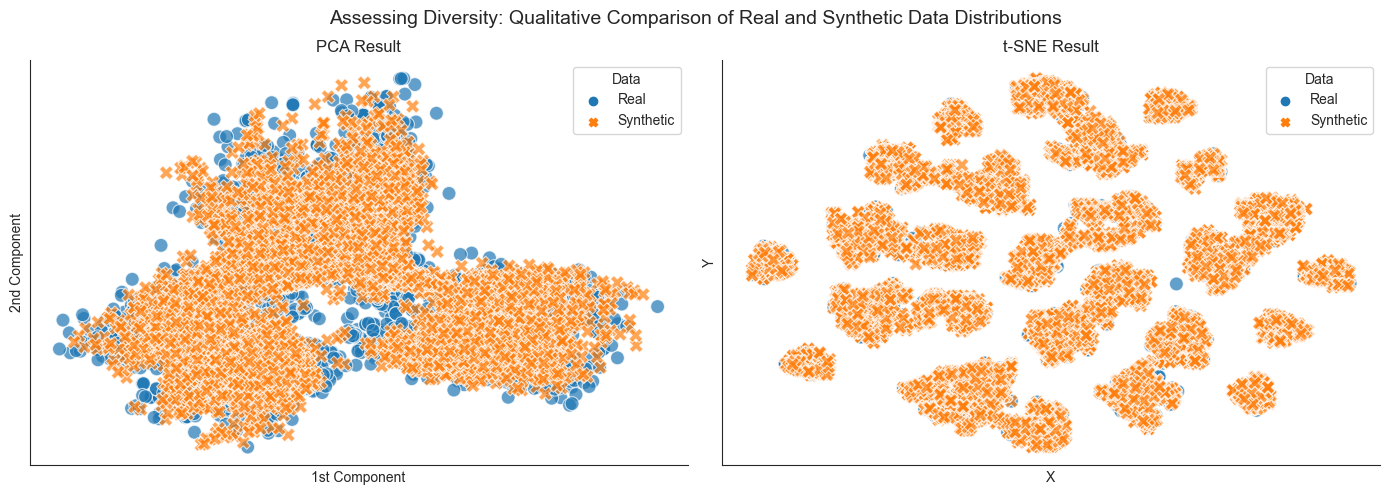

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(
    x="1st Component",
    y="2nd Component",
    data=pca_result,
    hue="Data",
    style="Data",
    ax=axes[0],
    s=100,  # Increase size of the points
    alpha=0.7,  # Increase transparency of the points
)
sns.despine()
axes[0].set_title("PCA Result")


sns.scatterplot(
    x="X",
    y="Y",
    data=tsne_result,
    hue="Data",
    style="Data",
    ax=axes[1],
    s=100,
    alpha=0.7,
)
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title("t-SNE Result")
fig.suptitle(
    "Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions",
    fontsize=14,
)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
# plotly tsne and pca plots
import plotly.express as px

pca_result["Data"] = pca_result["Data"].astype("category")
pca_result["Data"] = pca_result["Data"].cat.reorder_categories(["Real", "Synthetic"])

tsne_result["Data"] = tsne_result["Data"].astype("category")
tsne_result["Data"] = tsne_result["Data"].cat.reorder_categories(["Real", "Synthetic"])

fig = px.scatter(
    pca_result,
    x="1st Component",
    y="2nd Component",
    color="Data",
    symbol="Data",
    opacity=0.7,
    title="PCA Result",
)
fig.show()

fig = px.scatter(
    tsne_result,
    x="X",
    y="Y",
    color="Data",
    symbol="Data",
    opacity=0.7,
    title="t-SNE Result",
)
fig.show()

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[: len(synthetic_data)]
real_data.shape

(483712, 24, 27)

In [ ]:
synthetic_data.shape

(483712, 24, 27)

In [ ]:
n_series = real_data.shape[0]

In [ ]:
idx = np.arange(n_series)

In [ ]:
n_train = int(0.8 * n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
train_data = np.vstack((real_data[train_idx], synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], synthetic_data[test_idx]))

In [ ]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train), np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test), np.zeros(n_test)))

In [ ]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((773938, 24, 27), (773938,), (193486, 24, 27), (193486,))

## Create Classifier

In [ ]:
ts_classifier = Sequential(
    [
        GRU(27, input_shape=(24, 27), name="GRU"),
        Dense(1, activation="sigmoid", name="OUT"),
    ],
    name="Time_Series_Classifier",
)

In [ ]:
ts_classifier.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=[AUC(name="AUC"), "accuracy"]
)

In [ ]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 27)                4536      
                                                                 
 OUT (Dense)                 (None, 1)                 28        
                                                                 
Total params: 4,564
Trainable params: 4,564
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = ts_classifier.fit(
    x=train_data,
    y=train_labels,
    validation_data=(test_data, test_labels),
    epochs=250,
    batch_size=128,
    verbose=1,
)

Epoch 1/250
6047/6047 [==============================] - 49s 8ms/step - loss: 0.0373 - AUC: 0.9984 - accuracy: 0.9881 - val_loss: 0.1684 - val_AUC: 0.9816 - val_accuracy: 0.9585
Epoch 2/250
6047/6047 [==============================] - 49s 8ms/step - loss: 0.0210 - AUC: 0.9993 - accuracy: 0.9935 - val_loss: 0.0999 - val_AUC: 0.9934 - val_accuracy: 0.9689
Epoch 3/250
6047/6047 [==============================] - 50s 8ms/step - loss: 0.0131 - AUC: 0.9996 - accuracy: 0.9960 - val_loss: 0.0510 - val_AUC: 0.9970 - val_accuracy: 0.9850
Epoch 4/250
6047/6047 [==============================] - 49s 8ms/step - loss: 0.0086 - AUC: 0.9997 - accuracy: 0.9974 - val_loss: 0.0471 - val_AUC: 0.9982 - val_accuracy: 0.9843
Epoch 5/250
6047/6047 [==============================] - 50s 8ms/step - loss: 0.0061 - AUC: 0.9998 - accuracy: 0.9981 - val_loss: 0.0958 - val_AUC: 0.9943 - val_accuracy: 0.9736
Epoch 6/250
6047/6047 [==============================] - 49s 8ms/step - loss: 0.0043 - AUC: 0.9999 - accuracy:

KeyboardInterrupt: 

In [ ]:
ts_classifier.evaluate(x=test_data, y=test_labels)

56/56 [==============================] - 0s 2ms/step - loss: 3.3849 - AUC: 0.2817 - accuracy: 0.5307


[3.3848929405212402, 0.2817339301109314, 0.5306919813156128]

In [ ]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [ ]:
from matplotlib.ticker import FuncFormatter

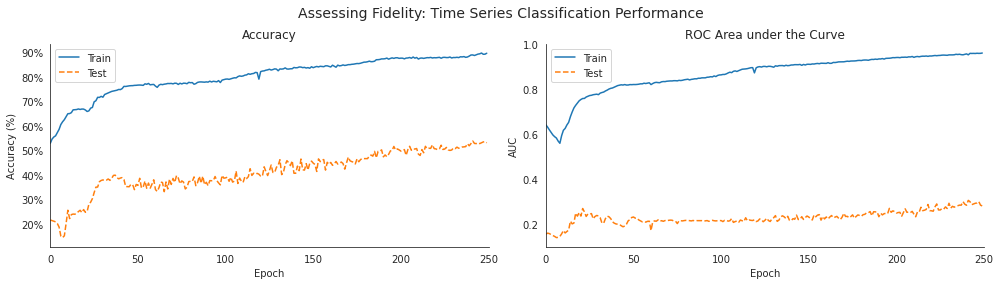

In [ ]:
sns.set_style("white")
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
history[["AUC", "val_AUC"]].rename(columns={"AUC": "Train", "val_AUC": "Test"}).plot(
    ax=axes[1], title="ROC Area under the Curve", style=["-", "--"], xlim=(0, 250)
)
history[["accuracy", "val_accuracy"]].rename(
    columns={"accuracy": "Train", "val_accuracy": "Test"}
).plot(ax=axes[0], title="Accuracy", style=["-", "--"], xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel("Epoch")

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:.0%}".format(y)))
axes[0].set_ylabel("Accuracy (%)")
axes[1].set_ylabel("AUC")
sns.despine()
fig.suptitle("Assessing Fidelity: Time Series Classification Performance", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

# Train on Synthetic, test on real: Assessing usefulness

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[: len(synthetic_data)]

In [ ]:
real_data.shape, synthetic_data.shape

((483712, 24, 27), (483712, 24, 27))

In [ ]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [ ]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((386969, 23, 27), (386969, 27), (96743, 23, 27), (96743, 27))

In [ ]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [ ]:
synthetic_train.shape, synthetic_label.shape

((483712, 23, 27), (483712, 27))

In [ ]:
def get_model():
    model = Sequential([GRU(12, input_shape=(23, 27)), Dense(27)])

    model.compile(optimizer=Adam(), loss=MeanAbsoluteError(name="MAE"))
    return model

In [ ]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(
    x=synthetic_train,
    y=synthetic_label,
    validation_data=(real_test_data, real_test_label),
    epochs=100,
    batch_size=128,
    verbose=1,
)

Epoch 1/100
3779/3779 [==============================] - 23s 6ms/step - loss: 0.0159 - val_loss: 0.0138
Epoch 2/100
3779/3779 [==============================] - 22s 6ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 3/100
3779/3779 [==============================] - 21s 6ms/step - loss: 0.0104 - val_loss: 0.0136
Epoch 4/100
3779/3779 [==============================] - 22s 6ms/step - loss: 0.0102 - val_loss: 0.0134
Epoch 5/100
3779/3779 [==============================] - 22s 6ms/step - loss: 0.0101 - val_loss: 0.0135
Epoch 6/100
3779/3779 [==============================] - 21s 5ms/step - loss: 0.0101 - val_loss: 0.0136
Epoch 7/100
3779/3779 [==============================] - 21s 5ms/step - loss: 0.0100 - val_loss: 0.0133
Epoch 8/100
3779/3779 [==============================] - 21s 6ms/step - loss: 0.0095 - val_loss: 0.0130
Epoch 9/100
3779/3779 [==============================] - 21s 6ms/step - loss: 0.0095 - val_loss: 0.0131
Epoch 10/100
3779/3779 [==============================] - 21s 6m

In [ ]:
ts_regression = get_model()
real_result = ts_regression.fit(
    x=real_train_data,
    y=real_train_label,
    validation_data=(real_test_data, real_test_label),
    epochs=100,
    batch_size=128,
    verbose=1,
)

In [ ]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(
    columns={"loss": "Train", "val_loss": "Test"}
)
real_result = pd.DataFrame(real_result.history).rename(
    columns={"loss": "Train", "val_loss": "Test"}
)

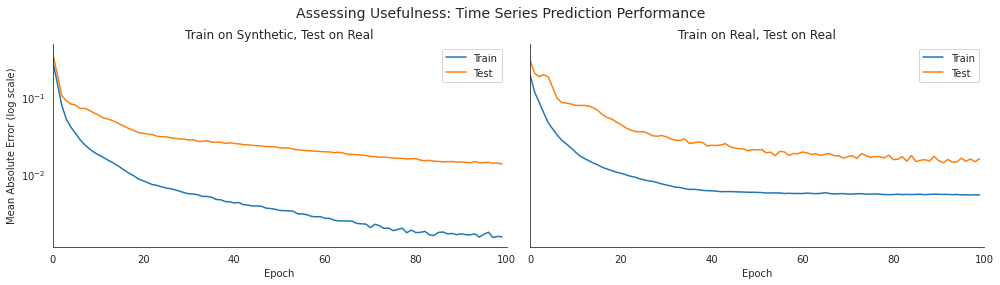

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(
    ax=axes[0], title="Train on Synthetic, Test on Real", logy=True, xlim=(0, 100)
)
real_result.plot(
    ax=axes[1], title="Train on Real, Test on Real", logy=True, xlim=(0, 100)
)
for i in [0, 1]:
    axes[i].set_xlabel("Epoch")
    axes[i].set_ylabel("Mean Absolute Error (log scale)")

sns.despine()
fig.suptitle("Assessing Usefulness: Time Series Prediction Performance", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)